In [1]:
import numpy as np
from src.utils import load_data

df_raw_AAPL = load_data('AAPL', '2009-01-01', '2025-01-01')
df_train_AAPL = df_raw_AAPL[df_raw_AAPL.index <= '2023-01-01']
df_test_AAPL = df_raw_AAPL[df_raw_AAPL.index > '2022-11-17']

df_raw_META = load_data('META', '2009-01-01', '2025-01-01')
df_train_META = df_raw_META[df_raw_META.index <= '2023-01-01']
df_test_META = df_raw_META[df_raw_META.index > '2022-11-17']

df_raw_MSFT = load_data('MSFT', '2009-01-01', '2025-01-01')
df_train_MSFT = df_raw_MSFT[df_raw_MSFT.index <= '2023-01-01']
df_test_MSFT = df_raw_MSFT[df_raw_MSFT.index > '2022-11-17']

df_raw_GOOG = load_data('GOOG', '2009-01-01', '2025-01-01')
df_train_GOOG = df_raw_GOOG[df_raw_GOOG.index <= '2023-01-01']
df_test_GOOG = df_raw_GOOG[df_raw_GOOG.index > '2022-11-17']

In [2]:
def compute_bh_equity(df):
    price = df["Close"].astype(float)
    log_returns = np.log(price / price.shift(1))
    equity = np.exp(log_returns.cumsum())
    return equity.fillna(1.0)

def compute_metrics_long(df):
    equity = compute_bh_equity(df)
    running_max = equity.cummax()
    max_dd = (equity / running_max - 1).min()
    daily_returns = np.log(df["Close"] / df["Close"].shift(1)).dropna()
    sharpe = (daily_returns.mean() / (daily_returns.std() + 1e-9)) * np.sqrt(252)
    downside = daily_returns[daily_returns < 0].std()
    sortino = (daily_returns.mean() / (downside + 1e-9)) * np.sqrt(252)
    hit_ratio = (daily_returns > 0).mean()

    # Wydruk do konsoli
    print(
        f"| MaxDD: {max_dd*100:6.2f}% "
        f"| Sharpe: {sharpe:5.2f} "
        f"| Sortino: {sortino:5.2f} "
        f"| Hit: {hit_ratio*100:5.1f}%"
    )

metrics_bh = compute_metrics_long(df_train_AAPL)
metrics_bh = compute_metrics_long(df_train_META)
metrics_bh = compute_metrics_long(df_train_MSFT)
metrics_bh = compute_metrics_long(df_train_GOOG)

| MaxDD: -43.80% | Sharpe:  0.92 | Sortino:  1.25 | Hit:  52.9%
| MaxDD: -76.74% | Sharpe:  0.45 | Sortino:  0.56 | Hit:  52.4%
| MaxDD: -37.15% | Sharpe:  0.79 | Sortino:  1.06 | Hit:  52.3%
| MaxDD: -44.60% | Sharpe:  0.62 | Sortino:  0.83 | Hit:  52.7%


In [3]:
import argparse
import pandas as pd
from src.mtrain import train
from src.model import DQNConfig
from src.plot import plot_last_episode
from src.env import TradingEnvConfig, TradingEnv

parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, default=1000)
parser.add_argument('--seed', type=int, default=42)
args, _ = parser.parse_known_args()

cfg = TradingEnvConfig(window=30)

Episode 050 | Sum(r_t):   0.1365 | MaxDD: -11.43% | Sharpe:  1.11 | Sortino:  1.36 | Hit:  36.5%| Eps:  0.96
Episode 100 | Sum(r_t):   0.0891 | MaxDD: -13.89% | Sharpe:  0.81 | Sortino:  1.07 | Hit:  29.4%| Eps:  0.92
Zapisano wagi do: dqns_AAPL/dqn_100_AAPL.pth
Episode 150 | Sum(r_t):  -0.3657 | MaxDD: -33.68% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  29.4%| Eps:  0.88
Episode 200 | Sum(r_t):  -0.0212 | MaxDD: -11.54% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  36.5%| Eps:  0.83
Zapisano wagi do: dqns_AAPL/dqn_200_AAPL.pth
Episode 250 | Sum(r_t):  -0.1340 | MaxDD: -26.87% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  34.1%| Eps:  0.79
Episode 300 | Sum(r_t):   0.2066 | MaxDD: -10.39% | Sharpe:  1.86 | Sortino:  2.65 | Hit:  42.1%| Eps:  0.75
Zapisano wagi do: dqns_AAPL/dqn_300_AAPL.pth
Episode 350 | Sum(r_t):  -0.1357 | MaxDD: -13.90% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  34.1%| Eps:  0.71
Episode 400 | Sum(r_t):  -0.0909 | MaxDD: -13.66% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  32.5%| Eps:

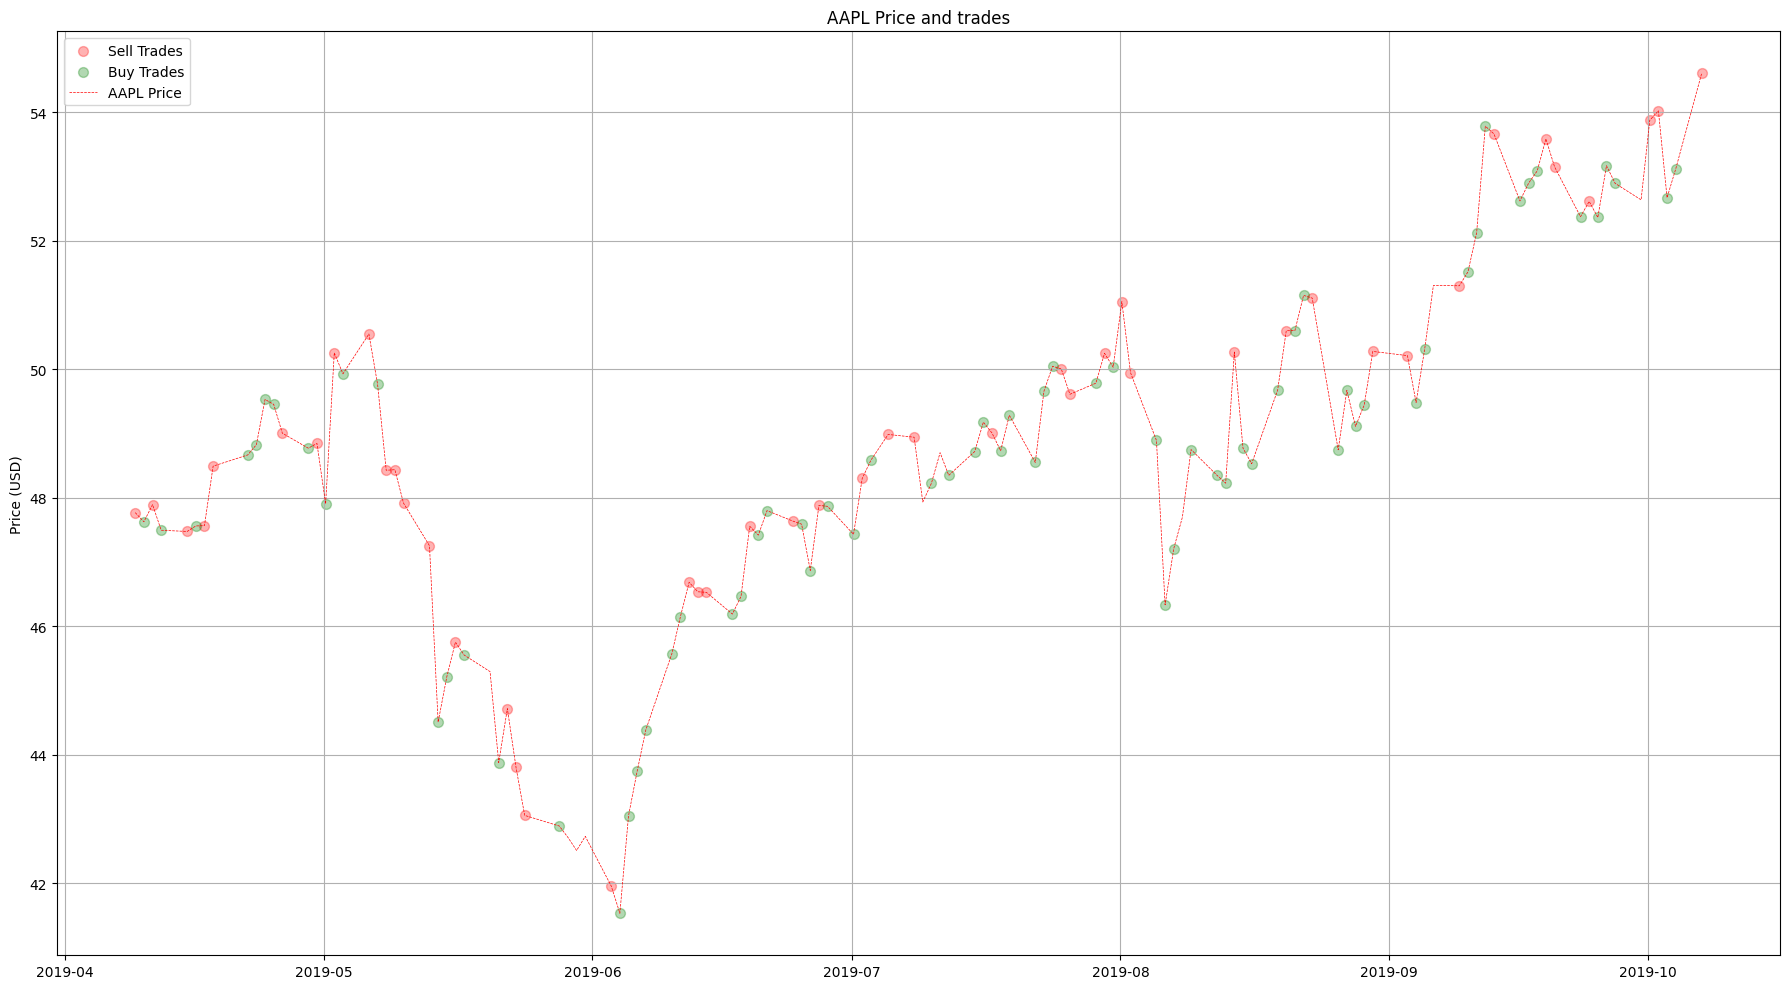

In [4]:
env_aapl = TradingEnv('AAPL', df_train_AAPL, df_train_AAPL.columns, cfg)

# 3) Trening DQN
dqn_cfg = DQNConfig()
qnet, ep_returns, last_ep_log, log_hist_aapl = train(
    env_aapl, dqn_cfg, episodes=args.episodes, seed=args.seed
)

log_hist_aapl = pd.DataFrame(log_hist_aapl, columns=['ep_return', 'maxDD', 'Sharpe', 'Sortino', 'HitRatio'])

# 4) Wykres ostatniego epizodu
plot_last_episode('AAPL', df_train_AAPL, last_ep_log)

Episode 050 | Sum(r_t):   0.1803 | MaxDD: -13.07% | Sharpe:  1.72 | Sortino:  1.97 | Hit:  41.3%| Eps:  0.96
Episode 100 | Sum(r_t):  -0.0239 | MaxDD: -11.10% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  29.4%| Eps:  0.92
Zapisano wagi do: dqns_MSFT/dqn_100_MSFT.pth
Episode 150 | Sum(r_t):  -0.1841 | MaxDD: -20.99% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  31.7%| Eps:  0.88
Episode 200 | Sum(r_t):  -0.1584 | MaxDD: -13.93% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  29.4%| Eps:  0.83
Zapisano wagi do: dqns_MSFT/dqn_200_MSFT.pth
Episode 250 | Sum(r_t):  -0.0327 | MaxDD: -20.18% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  31.0%| Eps:  0.79
Episode 300 | Sum(r_t):   0.1040 | MaxDD: -13.63% | Sharpe:  1.00 | Sortino:  1.88 | Hit:  40.5%| Eps:  0.75
Zapisano wagi do: dqns_MSFT/dqn_300_MSFT.pth
Episode 350 | Sum(r_t):   0.0719 | MaxDD: -12.96% | Sharpe:  0.87 | Sortino:  1.39 | Hit:  39.7%| Eps:  0.71
Episode 400 | Sum(r_t):   0.2286 | MaxDD:  -3.49% | Sharpe:  2.98 | Sortino:  5.60 | Hit:  41.3%| Eps:

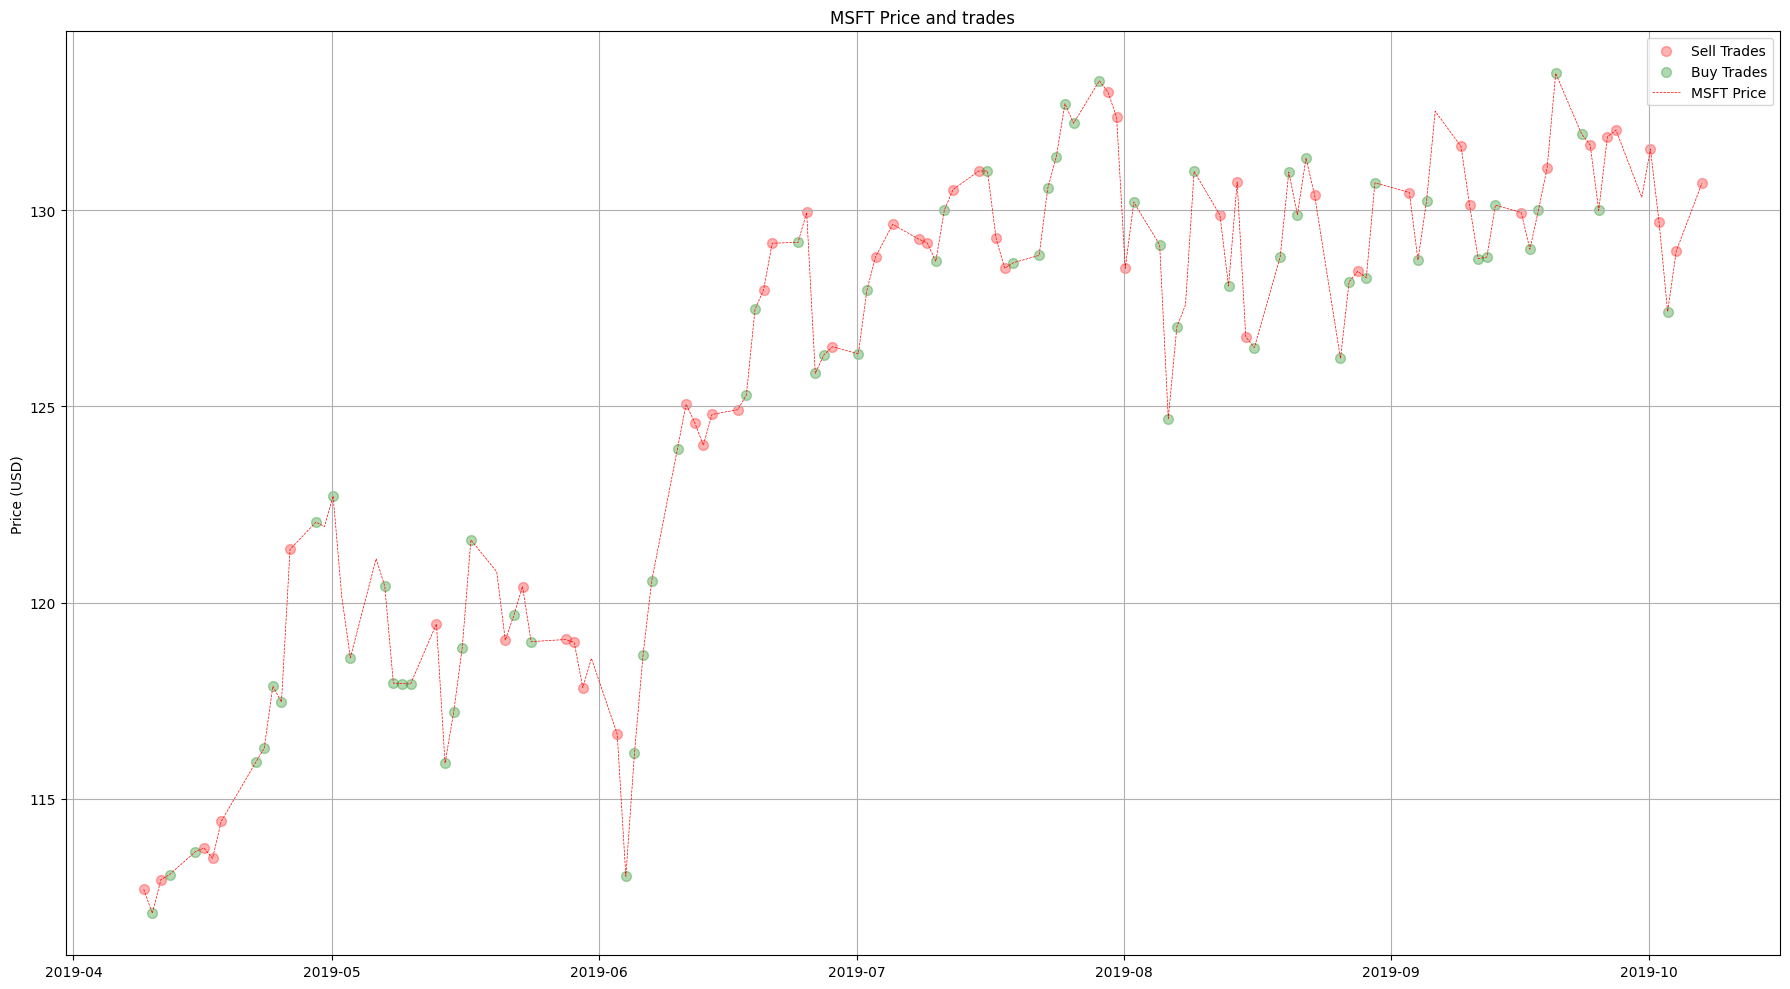

In [5]:
env_msft = TradingEnv('MSFT', df_train_MSFT, df_train_MSFT.columns, cfg)

# 3) Trening DQN
dqn_cfg = DQNConfig()
qnet, ep_returns, last_ep_log, log_hist_msft = train(
    env_msft, dqn_cfg, episodes=args.episodes, seed=args.seed
)

log_hist_msft = pd.DataFrame(log_hist_msft, columns=['ep_return', 'maxDD', 'Sharpe', 'Sortino', 'HitRatio'])

# 4) Wykres ostatniego epizodu
plot_last_episode('MSFT', df_train_MSFT, last_ep_log)

Episode 050 | Sum(r_t):  -0.0809 | MaxDD: -12.55% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  30.2%| Eps:  0.96
Episode 100 | Sum(r_t):  -0.0485 | MaxDD: -19.83% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  32.5%| Eps:  0.92
Zapisano wagi do: dqns_META/dqn_100_META.pth
Episode 150 | Sum(r_t):  -0.0134 | MaxDD: -29.48% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  34.1%| Eps:  0.88
Episode 200 | Sum(r_t):   0.0789 | MaxDD: -23.66% | Sharpe:  0.42 | Sortino:  0.62 | Hit:  33.3%| Eps:  0.83
Zapisano wagi do: dqns_META/dqn_200_META.pth
Episode 250 | Sum(r_t):   0.1305 | MaxDD: -43.01% | Sharpe:  0.43 | Sortino:  0.41 | Hit:  38.9%| Eps:  0.79
Episode 300 | Sum(r_t):   0.0627 | MaxDD: -22.83% | Sharpe:  0.33 | Sortino:  0.38 | Hit:  43.7%| Eps:  0.75
Zapisano wagi do: dqns_META/dqn_300_META.pth
Episode 350 | Sum(r_t):   0.8045 | MaxDD: -13.43% | Sharpe:  2.99 | Sortino:  6.46 | Hit:  48.4%| Eps:  0.71
Episode 400 | Sum(r_t):   0.7879 | MaxDD:  -5.73% | Sharpe:  5.99 | Sortino: 14.96 | Hit:  50.0%| Eps:

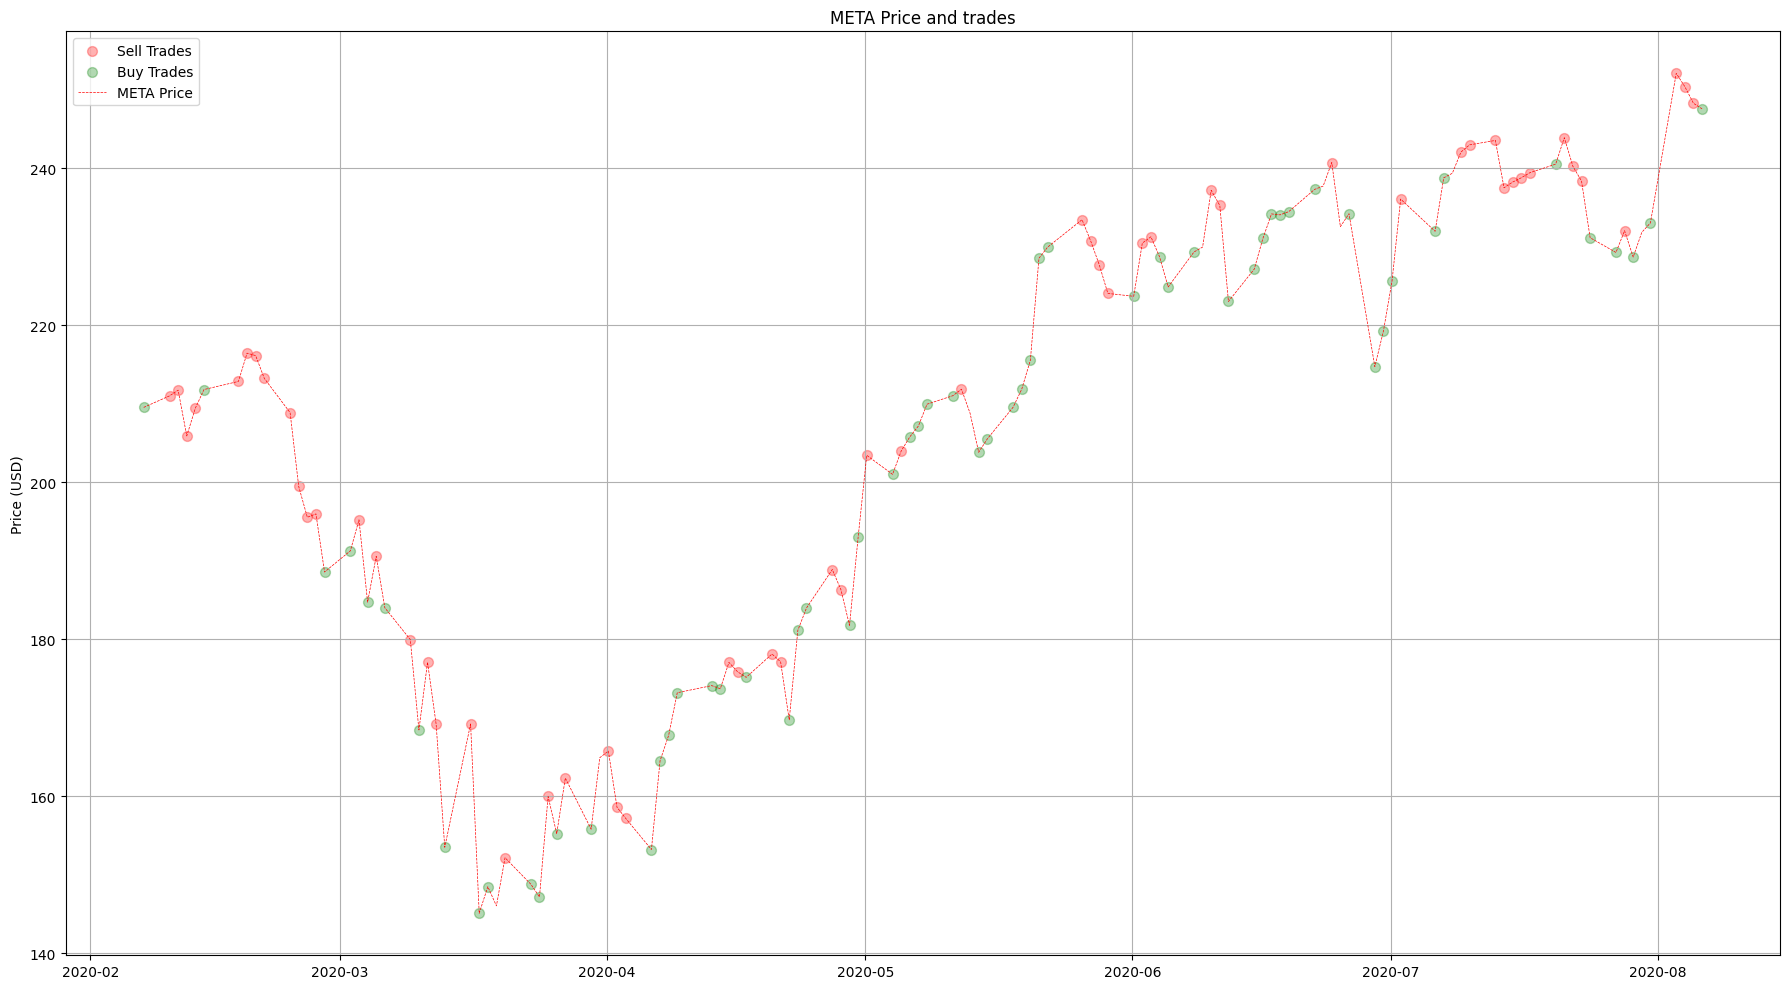

In [6]:
env_meta = TradingEnv('META', df_train_META, df_train_META.columns, cfg)

# 3) Trening DQN
dqn_cfg = DQNConfig()
qnet, ep_returns, last_ep_log, log_hist_meta = train(
    env_meta, dqn_cfg, episodes=args.episodes, seed=args.seed
)

log_hist_meta = pd.DataFrame(log_hist_meta, columns=['ep_return', 'maxDD', 'Sharpe', 'Sortino', 'HitRatio'])

# 4) Wykres ostatniego epizodu
plot_last_episode('META', df_train_META, last_ep_log)

Episode 050 | Sum(r_t):   0.1416 | MaxDD: -11.31% | Sharpe:  1.24 | Sortino:  1.47 | Hit:  34.9%| Eps:  0.96
Episode 100 | Sum(r_t):  -0.1738 | MaxDD: -23.01% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  30.2%| Eps:  0.92
Zapisano wagi do: dqns_GOOG/dqn_100_GOOG.pth
Episode 150 | Sum(r_t):  -0.2011 | MaxDD: -24.69% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  31.7%| Eps:  0.88
Episode 200 | Sum(r_t):  -0.1129 | MaxDD: -13.52% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  33.3%| Eps:  0.83
Zapisano wagi do: dqns_GOOG/dqn_200_GOOG.pth
Episode 250 | Sum(r_t):  -0.2129 | MaxDD: -34.96% | Sharpe:  0.00 | Sortino:  0.00 | Hit:  32.5%| Eps:  0.79
Episode 300 | Sum(r_t):   0.0383 | MaxDD:  -9.31% | Sharpe:  0.46 | Sortino:  0.74 | Hit:  32.5%| Eps:  0.75
Zapisano wagi do: dqns_GOOG/dqn_300_GOOG.pth
Episode 350 | Sum(r_t):   0.0347 | MaxDD:  -9.09% | Sharpe:  0.37 | Sortino:  0.56 | Hit:  38.9%| Eps:  0.71
Episode 400 | Sum(r_t):   0.0160 | MaxDD:  -4.59% | Sharpe:  0.23 | Sortino:  0.32 | Hit:  32.5%| Eps:

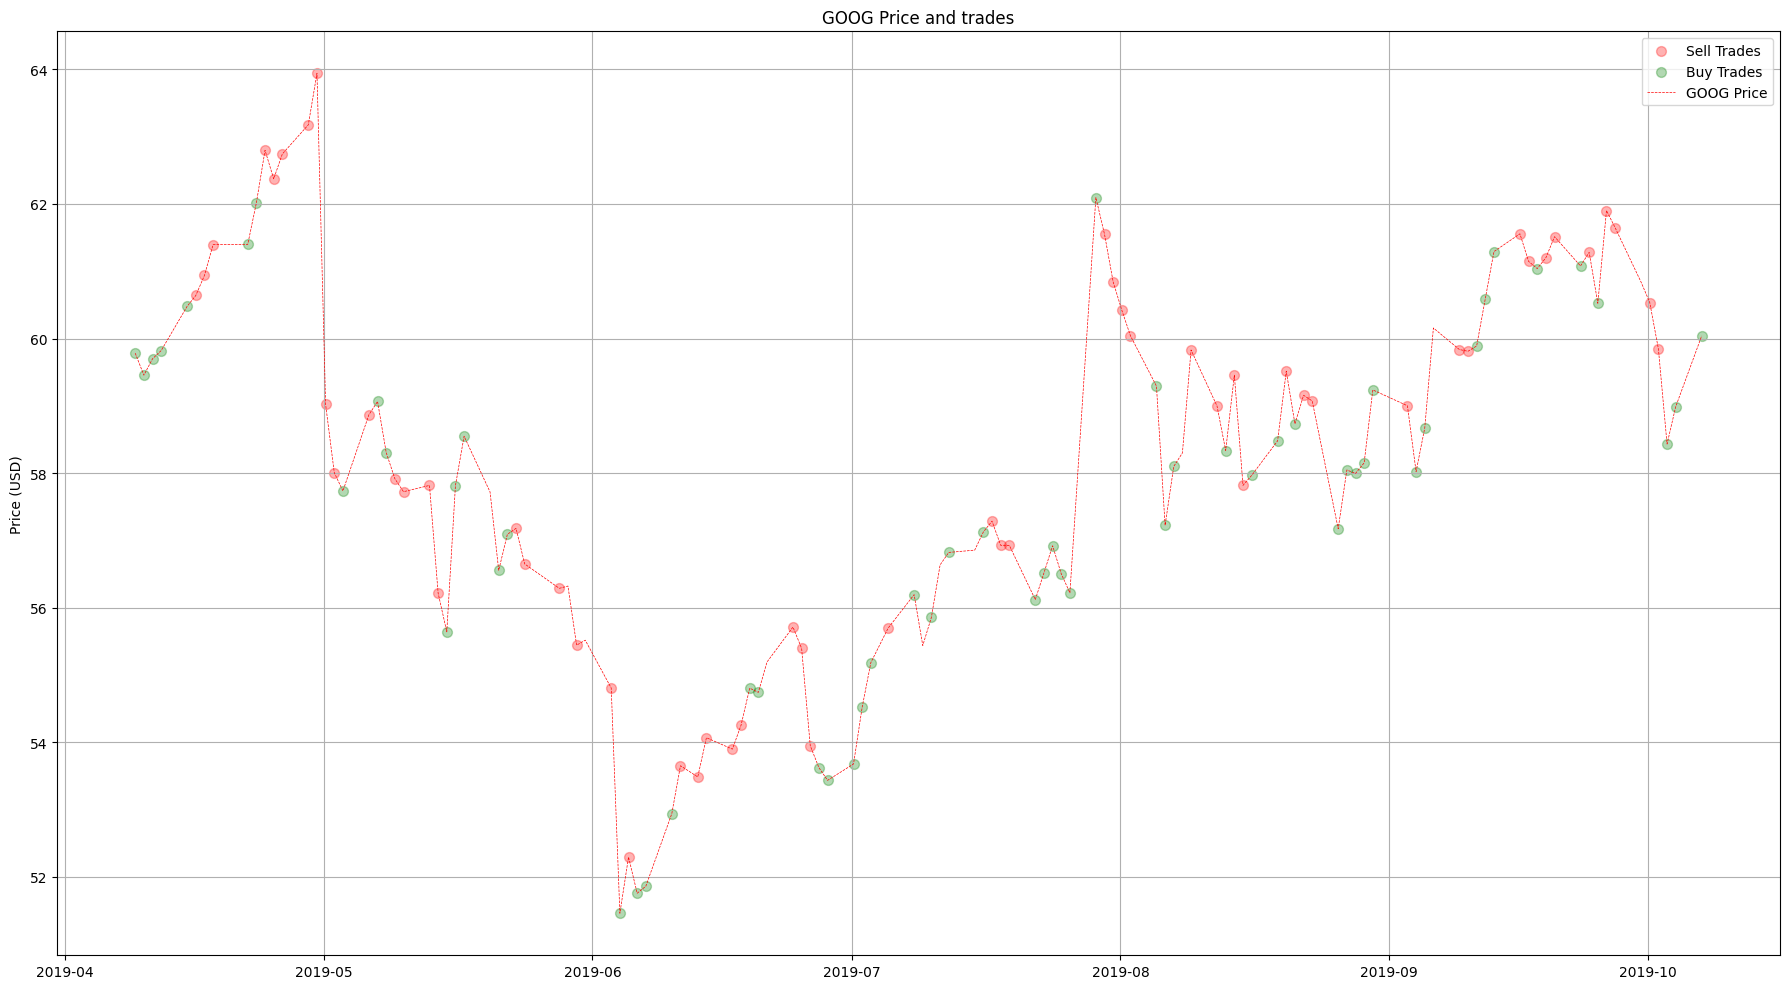

In [7]:
env_goog = TradingEnv('GOOG', df_train_GOOG, df_train_GOOG.columns, cfg)

# 3) Trening DQN
dqn_cfg = DQNConfig()
qnet, ep_returns, last_ep_log, log_hist_goog = train(
    env_goog, dqn_cfg, episodes=args.episodes, seed=args.seed
)

log_hist_goog = pd.DataFrame(log_hist_goog, columns=['ep_return', 'maxDD', 'Sharpe', 'Sortino', 'HitRatio'])

# 4) Wykres ostatniego epizodu
plot_last_episode('GOOG', df_train_GOOG, last_ep_log)

In [8]:
metrics_bh = compute_metrics_long(df_test_AAPL)
metrics_bh = compute_metrics_long(df_test_META)
metrics_bh = compute_metrics_long(df_test_MSFT)
metrics_bh = compute_metrics_long(df_test_GOOG)

| MaxDD: -17.36% | Sharpe:  1.11 | Sortino:  1.67 | Hit:  55.2%
| MaxDD: -18.43% | Sharpe:  2.11 | Sortino:  3.65 | Hit:  53.7%
| MaxDD: -15.49% | Sharpe:  1.18 | Sortino:  1.76 | Hit:  53.9%
| MaxDD: -22.28% | Sharpe:  1.07 | Sortino:  1.50 | Hit:  55.4%


In [9]:
import torch
from src.env import TradingEnv
from pathlib import Path

from src.model import QNetwork
from src.evaluate import evaluate_greedy

env_test = TradingEnv('AAPL', df_test_AAPL, df_test_AAPL.columns, cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_dim   = env_test.observation_space.shape[0]
n_actions = env_test.action_space.n

qnet = QNetwork(obs_dim, n_actions).to(device)

directory = Path('dqns_aapl')

col_list = []
log_dqns_aapl = pd.DataFrame(columns=['MaxDD', 'Sharpe', 'Sortino', 'Hit'])


for file in directory.iterdir():  

    state_dict = torch.load(Path(file), map_location="cpu", weights_only=True)

    qnet.load_state_dict(state_dict)
    qnet.eval()

    print(file)
    df_log_test, list_dqns_aapl  = evaluate_greedy(env_test, qnet, device=device)
    log_dqns_aapl = pd.concat([log_dqns_aapl, list_dqns_aapl], ignore_index=False)
    col_list.append(file.stem)

log_dqns_aapl.index = col_list

dqns_aapl\dqn_1000_AAPL.pth
| MaxDD: -24.83%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  42.9%
dqns_aapl\dqn_100_AAPL.pth
| MaxDD: -25.31%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  20.6%
dqns_aapl\dqn_200_AAPL.pth
| MaxDD: -27.92%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  29.4%
dqns_aapl\dqn_300_AAPL.pth
| MaxDD: -12.03%  | Sharpe:  0.80  | Sortino:  1.25  | Hit:  42.9%
dqns_aapl\dqn_400_AAPL.pth
| MaxDD: -25.20%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  48.4%
dqns_aapl\dqn_500_AAPL.pth
| MaxDD:  -9.93%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  46.0%
dqns_aapl\dqn_600_AAPL.pth


C:\Users\jasiu\AppData\Local\Temp\ipykernel_10648\3394921619.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_dqns_aapl = pd.concat([log_dqns_aapl, list_dqns_aapl], ignore_index=False)


| MaxDD: -24.51%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  39.7%
dqns_aapl\dqn_700_AAPL.pth
| MaxDD: -26.50%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  42.9%
dqns_aapl\dqn_800_AAPL.pth
| MaxDD: -25.73%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  35.7%
dqns_aapl\dqn_900_AAPL.pth
| MaxDD: -37.16%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  39.7%


In [10]:
log_dqns_aapl.sort_values(by='Sharpe', ascending=False)

,MaxDD,Sharpe,Sortino,Hit
dqn_300_AAPL,-0.120256,0.802945,1.252552,0.428571
dqn_1000_AAPL,-0.248263,0.000000,0.000000,0.428571
dqn_100_AAPL,-0.253127,0.000000,0.000000,0.206349
dqn_200_AAPL,-0.279178,0.000000,0.000000,0.293651
dqn_400_AAPL,-0.251987,0.000000,0.000000,0.484127
dqn_500_AAPL,-0.099309,0.000000,0.000000,0.460317
dqn_600_AAPL,-0.245141,0.000000,0.000000,0.396825
dqn_700_AAPL,-0.264967,0.000000,0.000000,0.428571
dqn_800_AAPL,-0.257259,0.000000,0.000000,0.357143
dqn_900_AAPL,-0.371614,0.000000,0.000000,0.396825


In [11]:
import torch
from src.env import TradingEnv
from pathlib import Path

from src.model import QNetwork
from src.evaluate import evaluate_greedy

env_test = TradingEnv('META', df_test_META, df_test_META.columns, cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_dim   = env_test.observation_space.shape[0]
n_actions = env_test.action_space.n

qnet = QNetwork(obs_dim, n_actions).to(device)

directory = Path('dqns_meta')

col_list = []
log_dqns_meta = pd.DataFrame(columns=['MaxDD', 'Sharpe', 'Sortino', 'Hit'])


for file in directory.iterdir():  

    state_dict = torch.load(Path(file), map_location="cpu", weights_only=True)

    qnet.load_state_dict(state_dict)
    qnet.eval()

    print(file)
    df_log_test, list_dqns_meta  = evaluate_greedy(env_test, qnet, device=device)
    log_dqns_meta = pd.concat([log_dqns_meta, list_dqns_meta], ignore_index=False)
    col_list.append(file.stem)

log_dqns_meta.index = col_list

dqns_meta\dqn_1000_META.pth
| MaxDD: -22.42%  | Sharpe:  1.09  | Sortino:  1.16  | Hit:  53.2%
dqns_meta\dqn_100_META.pth
| MaxDD: -15.15%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  17.5%
dqns_meta\dqn_200_META.pth
| MaxDD: -19.42%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  31.0%
dqns_meta\dqn_300_META.pth
| MaxDD: -15.87%  | Sharpe:  2.23  | Sortino:  6.03  | Hit:  42.9%
dqns_meta\dqn_400_META.pth
| MaxDD: -12.12%  | Sharpe:  2.52  | Sortino:  7.30  | Hit:  50.0%
dqns_meta\dqn_500_META.pth
| MaxDD: -15.36%  | Sharpe:  2.20  | Sortino:  5.76  | Hit:  46.0%
dqns_meta\dqn_600_META.pth
| MaxDD:  -8.58%  | Sharpe:  3.15  | Sortino:  8.53  | Hit:  51.6%


C:\Users\jasiu\AppData\Local\Temp\ipykernel_10648\2505353153.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_dqns_meta = pd.concat([log_dqns_meta, list_dqns_meta], ignore_index=False)


dqns_meta\dqn_700_META.pth
| MaxDD: -21.56%  | Sharpe:  1.16  | Sortino:  2.74  | Hit:  48.4%
dqns_meta\dqn_800_META.pth
| MaxDD: -10.48%  | Sharpe:  3.04  | Sortino:  8.73  | Hit:  54.8%
dqns_meta\dqn_900_META.pth
| MaxDD: -15.03%  | Sharpe:  2.88  | Sortino:  7.98  | Hit:  56.3%


In [12]:
log_dqns_meta.sort_values(by='Sharpe', ascending=False)

,MaxDD,Sharpe,Sortino,Hit
dqn_600_META,-0.085838,3.151209,8.529850,0.515873
dqn_800_META,-0.104779,3.036398,8.733677,0.547619
dqn_900_META,-0.150325,2.883329,7.979712,0.563492
dqn_400_META,-0.121198,2.523475,7.297616,0.500000
dqn_300_META,-0.158746,2.231347,6.028192,0.428571
dqn_500_META,-0.153638,2.203148,5.760811,0.460317
dqn_700_META,-0.215634,1.159388,2.740743,0.484127
dqn_1000_META,-0.224198,1.086569,1.157351,0.531746
dqn_100_META,-0.151521,0.000000,0.000000,0.174603
dqn_200_META,-0.194171,0.000000,0.000000,0.309524


In [13]:
import torch
from src.env import TradingEnv
from pathlib import Path

from src.model import QNetwork
from src.evaluate import evaluate_greedy

env_test = TradingEnv('GOOG', df_test_GOOG, df_test_GOOG.columns, cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_dim   = env_test.observation_space.shape[0]
n_actions = env_test.action_space.n

qnet = QNetwork(obs_dim, n_actions).to(device)

directory = Path('dqns_goog')

col_list = []
log_dqns_goog = pd.DataFrame(columns=['MaxDD', 'Sharpe', 'Sortino', 'Hit'])


for file in directory.iterdir():  

    state_dict = torch.load(Path(file), map_location="cpu", weights_only=True)

    qnet.load_state_dict(state_dict)
    qnet.eval()

    print(file)
    df_log_test, list_dqns_goog  = evaluate_greedy(env_test, qnet, device=device)
    log_dqns_goog = pd.concat([log_dqns_goog, list_dqns_goog], ignore_index=False)
    col_list.append(file.stem)

log_dqns_goog.index = col_list

dqns_goog\dqn_1000_GOOG.pth
| MaxDD: -34.77%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  47.6%
dqns_goog\dqn_100_GOOG.pth
| MaxDD: -31.23%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  25.4%
dqns_goog\dqn_200_GOOG.pth
| MaxDD:  -9.68%  | Sharpe:  0.79  | Sortino:  1.45  | Hit:  35.7%
dqns_goog\dqn_300_GOOG.pth
| MaxDD: -29.01%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  31.7%
dqns_goog\dqn_400_GOOG.pth
| MaxDD: -19.08%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  39.7%
dqns_goog\dqn_500_GOOG.pth
| MaxDD: -25.70%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  41.3%
dqns_goog\dqn_600_GOOG.pth


C:\Users\jasiu\AppData\Local\Temp\ipykernel_10648\258725687.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_dqns_goog = pd.concat([log_dqns_goog, list_dqns_goog], ignore_index=False)


| MaxDD: -29.63%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  45.2%
dqns_goog\dqn_700_GOOG.pth
| MaxDD: -25.49%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  42.9%
dqns_goog\dqn_800_GOOG.pth
| MaxDD: -25.79%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  44.4%
dqns_goog\dqn_900_GOOG.pth
| MaxDD: -33.55%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  46.0%


In [14]:
log_dqns_goog.sort_values(by='Sharpe', ascending=False)

,MaxDD,Sharpe,Sortino,Hit
dqn_200_GOOG,-0.096756,0.792666,1.451636,0.357143
dqn_1000_GOOG,-0.347736,0.000000,0.000000,0.476190
dqn_100_GOOG,-0.312336,0.000000,0.000000,0.253968
dqn_300_GOOG,-0.290146,0.000000,0.000000,0.317460
dqn_400_GOOG,-0.190811,0.000000,0.000000,0.396825
dqn_500_GOOG,-0.256989,0.000000,0.000000,0.412698
dqn_600_GOOG,-0.296323,0.000000,0.000000,0.452381
dqn_700_GOOG,-0.254860,0.000000,0.000000,0.428571
dqn_800_GOOG,-0.257905,0.000000,0.000000,0.444444
dqn_900_GOOG,-0.335503,0.000000,0.000000,0.460317


In [15]:
import torch
from src.env import TradingEnv
from pathlib import Path

from src.model import QNetwork
from src.evaluate import evaluate_greedy

env_test = TradingEnv('MSFT', df_test_MSFT, df_test_MSFT.columns, cfg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_dim   = env_test.observation_space.shape[0]
n_actions = env_test.action_space.n

qnet = QNetwork(obs_dim, n_actions).to(device)

directory = Path('dqns_msft')

col_list = []
log_dqns_msft = pd.DataFrame(columns=['MaxDD', 'Sharpe', 'Sortino', 'Hit'])


for file in directory.iterdir():  

    state_dict = torch.load(Path(file), map_location="cpu", weights_only=True)

    qnet.load_state_dict(state_dict)
    qnet.eval()

    print(file)
    df_log_test, list_dqns_msft  = evaluate_greedy(env_test, qnet, device=device)
    log_dqns_msft = pd.concat([log_dqns_msft, list_dqns_msft], ignore_index=False)
    col_list.append(file.stem)

log_dqns_msft.index = col_list

dqns_msft\dqn_1000_MSFT.pth
| MaxDD: -15.70%  | Sharpe:  0.65  | Sortino:  1.10  | Hit:  50.8%
dqns_msft\dqn_100_MSFT.pth
| MaxDD: -11.56%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  22.2%
dqns_msft\dqn_200_MSFT.pth
| MaxDD: -18.25%  | Sharpe:  0.00  | Sortino:  0.00  | Hit:  34.9%
dqns_msft\dqn_300_MSFT.pth
| MaxDD: -12.27%  | Sharpe:  1.54  | Sortino:  2.29  | Hit:  44.4%
dqns_msft\dqn_400_MSFT.pth
| MaxDD: -21.32%  | Sharpe:  0.85  | Sortino:  1.27  | Hit:  47.6%
dqns_msft\dqn_500_MSFT.pth
| MaxDD: -19.27%  | Sharpe:  2.33  | Sortino:  3.99  | Hit:  52.4%


C:\Users\jasiu\AppData\Local\Temp\ipykernel_10648\3777392775.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_dqns_msft = pd.concat([log_dqns_msft, list_dqns_msft], ignore_index=False)


dqns_msft\dqn_600_MSFT.pth
| MaxDD: -16.76%  | Sharpe:  1.05  | Sortino:  1.95  | Hit:  45.2%
dqns_msft\dqn_700_MSFT.pth
| MaxDD: -11.75%  | Sharpe:  2.43  | Sortino:  4.02  | Hit:  43.7%
dqns_msft\dqn_800_MSFT.pth
| MaxDD: -18.07%  | Sharpe:  1.50  | Sortino:  2.35  | Hit:  42.1%
dqns_msft\dqn_900_MSFT.pth
| MaxDD: -16.58%  | Sharpe:  0.41  | Sortino:  0.66  | Hit:  46.8%


In [16]:
log_dqns_msft.sort_values(by='Sharpe', ascending=False)

,MaxDD,Sharpe,Sortino,Hit
dqn_700_MSFT,-0.117490,2.434382,4.016659,0.436508
dqn_500_MSFT,-0.192746,2.326206,3.987157,0.523810
dqn_300_MSFT,-0.122691,1.539060,2.290898,0.444444
dqn_800_MSFT,-0.180749,1.499543,2.351763,0.420635
dqn_600_MSFT,-0.167623,1.050539,1.952258,0.452381
dqn_400_MSFT,-0.213201,0.846022,1.268868,0.476190
dqn_1000_MSFT,-0.157010,0.651368,1.099101,0.507937
dqn_900_MSFT,-0.165755,0.411867,0.660465,0.468254
dqn_100_MSFT,-0.115592,0.000000,0.000000,0.222222
dqn_200_MSFT,-0.182503,0.000000,0.000000,0.349206
